In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.1 MB/s eta 0:00:00


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/UTKFace.zip' -d '/content/UTKFace'


Streaming output truncated to the last 5000 lines.
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_1_20170116192938845.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_1_20170117181950281.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_1_20170120222553113.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_1_20170120222956787.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_1_20170120223004304.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_2_20170104210010763.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_2_20170112215433623.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_2_20170112221930338.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_2_20170116192925824.jpg.chip.jpg  
  inflating: /content/UTKFace/utkcropped/utkcropped/53_0_2_20170116192934154.jpg.chip.jpg  
  inflating: /content/UTKFace

In [ ]:
# نمایش چند فایل اول از دیتاست
for fname in os.listdir('/content/UTKFace/utkcropped')[:10]:
    print(fname)

56_0_3_20170119180731484.jpg.chip.jpg
77_0_0_20170111222228671.jpg.chip.jpg
35_0_1_20170116225124900.jpg.chip.jpg
71_0_1_20170113175251268.jpg.chip.jpg
49_0_0_20170104185659750.jpg.chip.jpg
29_0_1_20170113173016611.jpg.chip.jpg
56_1_3_20170119183420176.jpg.chip.jpg
24_1_3_20170104231939707.jpg.chip.jpg
56_0_0_20170117165731095.jpg.chip.jpg
11_1_4_20170103201747167.jpg.chip.jpg


#Creating CSV file from UTKFace Image Dataset

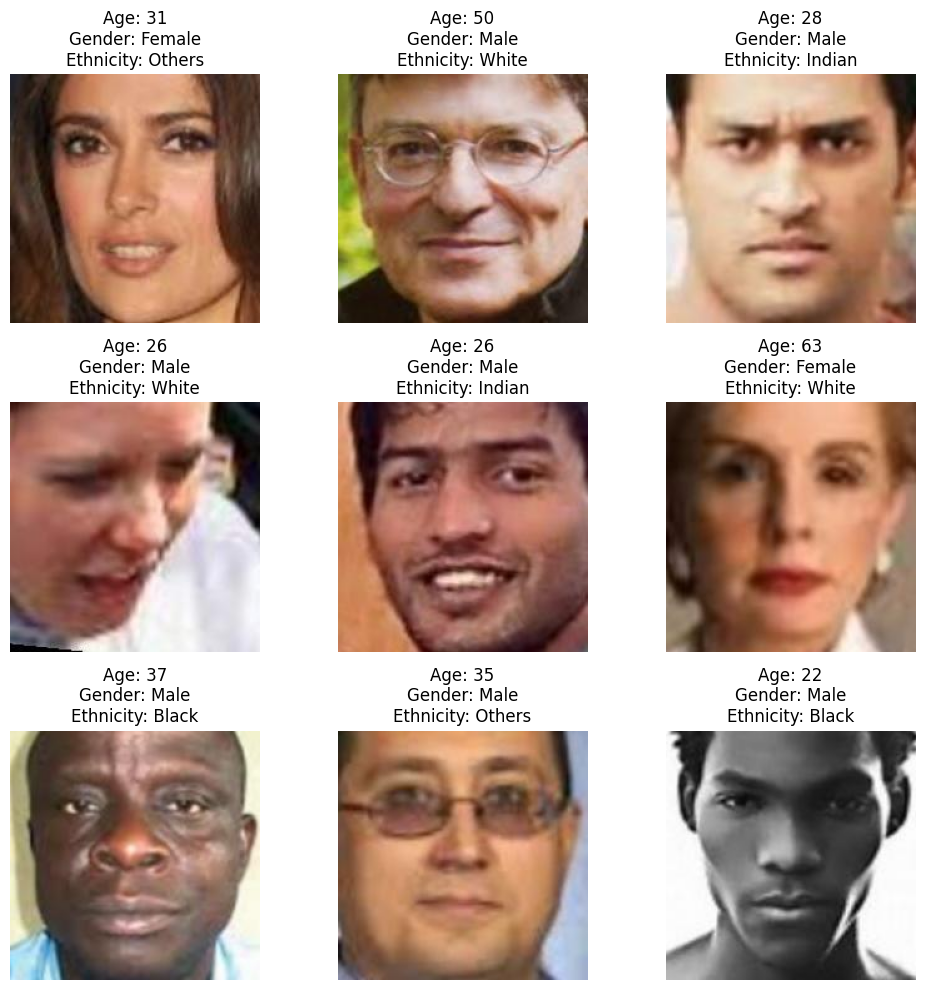

In [ ]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = '/content/UTKFace/utkcropped'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()

#Data Frame

In [ ]:
dataset_dir = '/content/UTKFace/utkcropped'
ll = os.listdir(dataset_dir)
ll

['28_0_0_20170117180145941.jpg.chip.jpg',
 '21_0_4_20161223214759249.jpg.chip.jpg',
 '42_0_2_20170104184350086.jpg.chip.jpg',
 '32_0_2_20170116162046640.jpg.chip.jpg',
 '24_1_0_20170105183859832.jpg.chip.jpg',
 '67_0_0_20170120224558687.jpg.chip.jpg',
 '28_1_2_20170116172552663.jpg.chip.jpg',
 '27_1_1_20170117013845090.jpg.chip.jpg',
 '29_1_1_20170112235118232.jpg.chip.jpg',
 '8_1_4_20170103212955884.jpg.chip.jpg',
 '46_0_0_20170119150223726.jpg.chip.jpg',
 '80_1_0_20170110143302067.jpg.chip.jpg',
 '35_1_4_20170117201436958.jpg.chip.jpg',
 '34_1_1_20170116012243049.jpg.chip.jpg',
 '21_1_1_20170116233611534.jpg.chip.jpg',
 '3_0_2_20161219204644036.jpg.chip.jpg',
 '80_0_0_20170111211508161.jpg.chip.jpg',
 '32_0_3_20170117182128437.jpg.chip.jpg',
 '85_1_0_20170110173744770.jpg.chip.jpg',
 '29_0_0_20170104165027441.jpg.chip.jpg',
 '27_0_2_20170119193328922.jpg.chip.jpg',
 '55_0_0_20170120223715854.jpg.chip.jpg',
 '90_1_0_20170110175738208.jpg.chip.jpg',
 '79_0_1_20170111223356803.jpg.chip.

In [ ]:
# Path to the UTKFace dataset directory
dataset_dir = '/content/UTKFace/utkcropped'

# Initialize lists to store data
image_names = []
ages = []
ethnicities = []
genders = []

# Iterate through files in the directory
for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'):
        parts = filename.split('_')
        # Format: [age]_[gender]_[ethnicity]_[other_info].jpg
        if len(parts) < 4:
          print(filename)
          continue
        #
        age = int(parts[0]) # because it was string, that's why we used int()
        gender = 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]
        #
        if age > 80: # it doesn't save more than 80 years old.
          continue

        #save in those four empty lists
        image_names.append(filename) #list of all of images'names
        ages.append(age)             #list of all of ages
        ethnicities.append(ethnicity)
        genders.append(gender)

#outside for
# Create a DataFrame from the lists
data = {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_filename = '/content/utkface_dataset.csv'
df.to_csv(csv_filename, index=False) #convert df to csv/ index=False means dont number the rows

print(f"CSV file '{csv_filename}' created successfully.")

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg
61_3_20170109150557335.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
CSV file '/content/utkface_dataset.csv' created successfully.


In [ ]:
df.head()

,image_name,age,ethnicity,gender
0,31_1_1_20170116170019856.jpg.chip.jpg,31,Black,Female
1,24_1_2_20170116171034407.jpg.chip.jpg,24,Asian,Female
2,29_0_3_20170104220737116.jpg.chip.jpg,29,Indian,Male
3,35_0_0_20170117183000621.jpg.chip.jpg,35,White,Male
4,26_0_3_20170117153930604.jpg.chip.jpg,26,Indian,Male


#analysis of dataset

(array([2896., 1179., 2828., 6772., 3324., 1571., 1997., 1180.,  864.,
         554.]),
 array([ 1. ,  8.9, 16.8, 24.7, 32.6, 40.5, 48.4, 56.3, 64.2, 72.1, 80. ]),
 <BarContainer object of 10 artists>)

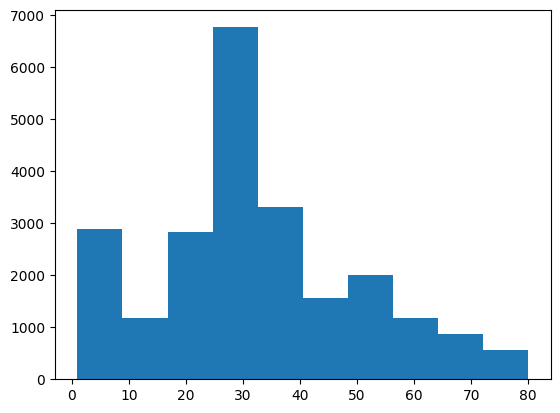

In [ ]:
plt.hist(df.age)

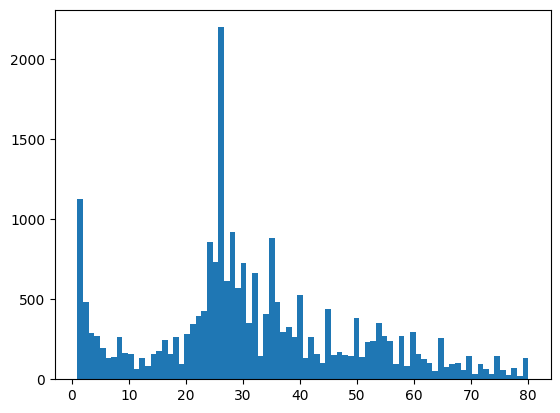

In [ ]:
plt.hist(df.age, bins=len(df.age.unique())); # bins the same number of ages to increase the number of bins

In [ ]:
df.age.describe()

,age
count,23165.000000
mean,32.024218
std,18.227409
min,1.000000
25%,23.000000
50%,29.000000
75%,42.000000
max,80.000000


In [ ]:
df.age.value_counts()

,count
age,
26,2197
1,1123
28,918
35,880
24,859
...,...
64,50
71,33
74,32


(array([10957.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 12208.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

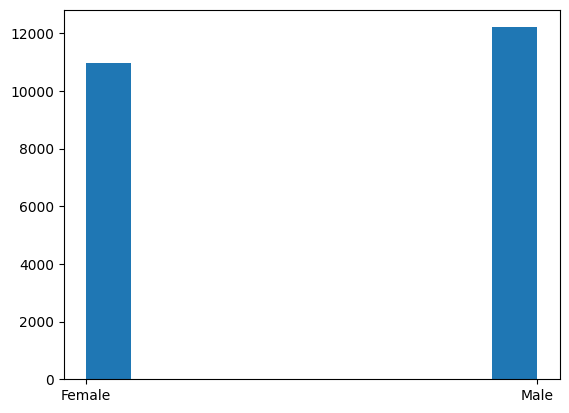

In [ ]:
plt.hist(df.gender)

(array([10957., 12208.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

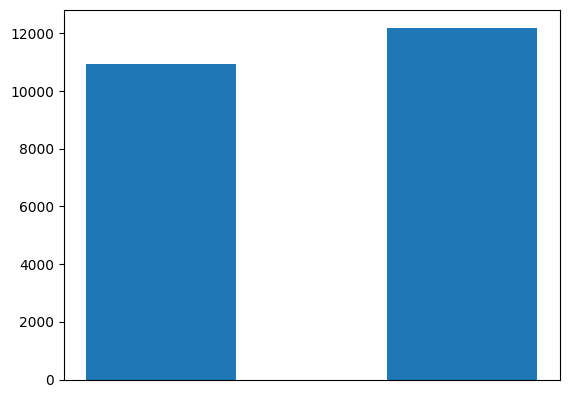

In [ ]:
plt.hist(df.gender, bins=2, rwidth=0.5) #rwidth for having space between columns and bins

In [ ]:
df.gender.value_counts()

,count
gender,
Male,12208
Female,10957


(array([4478.,    0., 3952.,    0.,    0., 3348.,    0., 9698.,    0.,
        1689.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

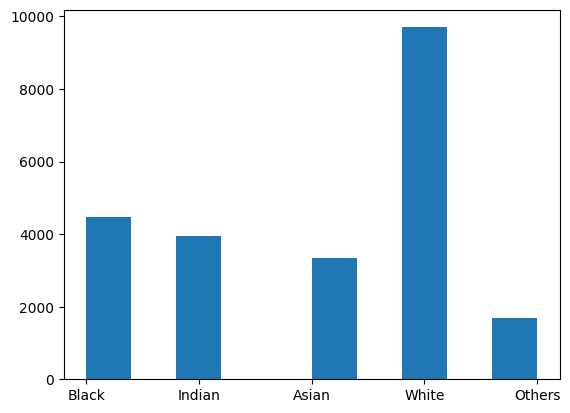

In [ ]:
plt.hist(df.ethnicity)

(array([4478., 3952., 3348., 9698., 1689.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

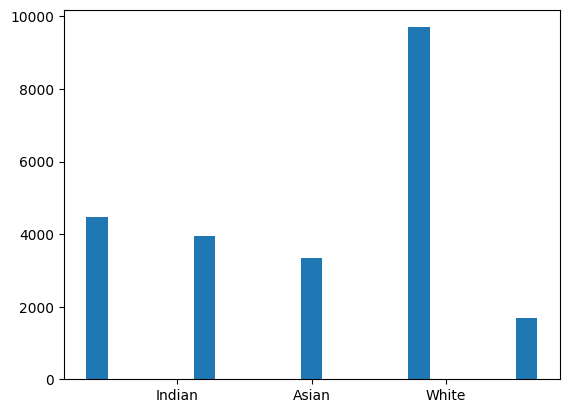

In [ ]:
plt.hist(df.ethnicity, bins=len(df.ethnicity.unique()), rwidth=0.2)

In [ ]:
df.ethnicity.value_counts()

,count
ethnicity,
White,9698
Black,4478
Indian,3952
Asian,3348
Others,1689


#split the dataset to train, test, validation

In [ ]:
df_train, temp = train_test_split(df, test_size=0.3, stratify=df.age, random_state=42) #taghsim be train and test/random_state: ta in taghsim bandi hamishe saabet bemooneh/ stratify: bar mabnaay toziye age rasm mikone
df_test, df_valid = train_test_split(temp, test_size=0.5, stratify=temp.age, random_state=42) #taghsim be valid and test

df_train.shape, df_test.shape, df_valid.shape

((16215, 4), (3475, 4), (3475, 4))

In [ ]:
df_train.head()

,image_name,age,ethnicity,gender
6444,58_0_0_20170120224625496.jpg.chip.jpg,58,White,Male
4332,24_0_4_20170103234945243.jpg.chip.jpg,24,Others,Male
17290,28_1_1_20170114031123751.jpg.chip.jpg,28,Black,Female
911,6_1_1_20170117201200086.jpg.chip.jpg,6,Black,Female
15593,52_1_0_20170109142345793.jpg.chip.jpg,52,White,Female


#analysis of train, test, and validation datasets

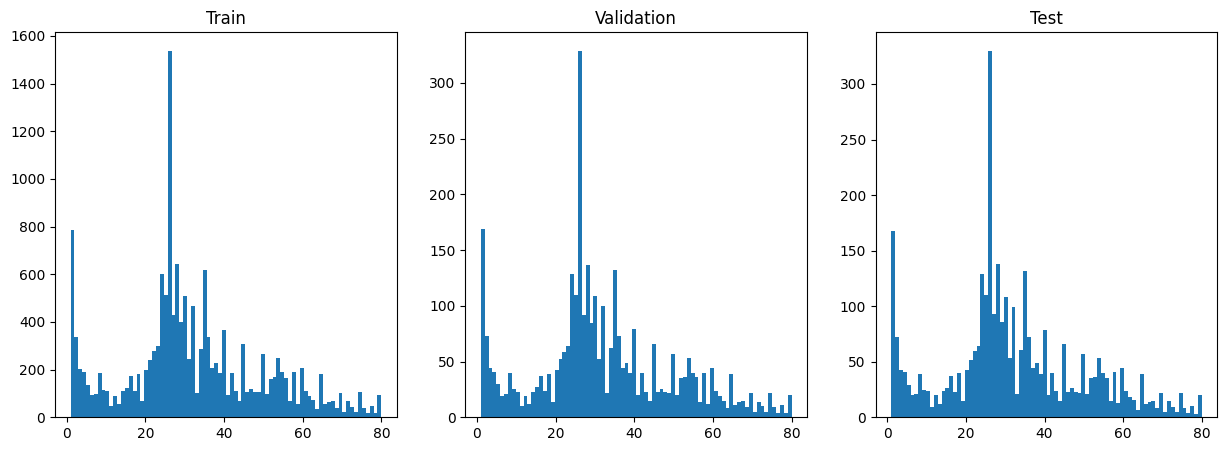

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

#tozi hateshoon be ham nazdik hastand.

#saving train_csv, test_csv, valid_csv

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


#transformations

In [ ]:
#transforms from torchvision
#size images for train and test bayad yeki bashan.


train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Custom Dataset

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file #train_csv, test_csv. valid_csv
      self.transform = transform
      self.data = pd.read_csv(csv_file)  # getting data here
      self.gender_dict = {'Male': 0, 'Female': 1}
      # self.ethnicity_dict = {}

    def __len__(self):
      return len(self.data)  #number of samples (sample size)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]

      #img_name = sample.image_name
      #img = Image.open(os.path.join(self.root_dir, img_name))

      #age = torch.tensor([sample.age], dtype=torch.float32)
      ##ethnicity = sample.ethnicity

      #img = self.transform(img)
      img_name = sample.image_name
      img = Image.open(os.path.join(self.root_dir, img_name))

      age = torch.tensor([sample.age], dtype=torch.float32)
      gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
      ethnicity = sample.ethnicity

      img = self.transform(img)

      #return sample

      return img, age#, gender, ethnicity

In [ ]:
#creating object
temp_dataset = UTKDataset(root_dir='/content/UTKFace/utkcropped',
                          csv_file='/content/valid_set.csv',
                          transform=test_transform)

temp_dataset.data, len(temp_dataset)
temp_dataset[0]


(tensor([[[-0.0629,  0.5193,  1.2899,  ...,  1.7352,  1.8893,  1.9064],
          [ 0.0227,  0.6563,  1.3927,  ...,  1.7009,  1.8893,  1.9578],
          [ 0.1083,  0.8276,  1.4954,  ...,  1.5982,  1.8208,  1.9064],
          ...,
          [-0.5424, -0.5596, -0.4911,  ..., -0.1143, -0.2171, -0.2684],
          [-0.5596, -0.5596, -0.4911,  ..., -0.0972, -0.1657, -0.2171],
          [-0.5596, -0.5596, -0.4911,  ..., -0.0458, -0.1143, -0.1657]],
 
         [[-0.6527, -0.0924,  0.7304,  ...,  1.6408,  1.7983,  1.8333],
          [-0.5476,  0.0651,  0.8354,  ...,  1.6232,  1.8508,  1.9209],
          [-0.4601,  0.2227,  0.9230,  ...,  1.5882,  1.8158,  1.9384],
          ...,
          [-0.8803, -0.8803, -0.8277,  ..., -0.3901, -0.5476, -0.6527],
          [-0.8803, -0.8803, -0.8102,  ..., -0.3550, -0.4951, -0.6001],
          [-0.8803, -0.8803, -0.8102,  ..., -0.3025, -0.4251, -0.5301]],
 
         [[-0.9853, -0.4450,  0.3393,  ...,  1.8034,  1.9603,  1.9951],
          [-0.9330, -0.3055,

In [ ]:
temp_dataset[10][1]

tensor([20.])

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file #train_csv, test_csv. valid_csv
      self.transform = transform
      self.data = pd.read_csv(csv_file)  # getting data here
      self.gender_dict = {'Male': 0, 'Female': 1}
      # self.ethnicity_dict = {}

    def __len__(self):
      return len(self.data)  #number of samples (sample size)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]

      img_name = sample.image_name
      img = Image.open(os.path.join(self.root_dir, img_name)) #making address for images (Image.open baraye PIL)

      #labels
      age = torch.tensor([sample.age], dtype=torch.float32)
      gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
      ethnicity = sample.ethnicity

      img = self.transform(img)

      #return img1
      #return img1,age, gender, ethnicity
      return img,age#, gender, ethnicity

In [ ]:
#creating object
temp_dataset = UTKDataset(root_dir='/content/UTKFace/utkcropped',
                          csv_file='/content/valid_set.csv',
                          transform=test_transform)

temp_dataset.data, len(temp_dataset)
temp_dataset[0]


(tensor([[[-0.0629,  0.5193,  1.2899,  ...,  1.7352,  1.8893,  1.9064],
          [ 0.0227,  0.6563,  1.3927,  ...,  1.7009,  1.8893,  1.9578],
          [ 0.1083,  0.8276,  1.4954,  ...,  1.5982,  1.8208,  1.9064],
          ...,
          [-0.5424, -0.5596, -0.4911,  ..., -0.1143, -0.2171, -0.2684],
          [-0.5596, -0.5596, -0.4911,  ..., -0.0972, -0.1657, -0.2171],
          [-0.5596, -0.5596, -0.4911,  ..., -0.0458, -0.1143, -0.1657]],
 
         [[-0.6527, -0.0924,  0.7304,  ...,  1.6408,  1.7983,  1.8333],
          [-0.5476,  0.0651,  0.8354,  ...,  1.6232,  1.8508,  1.9209],
          [-0.4601,  0.2227,  0.9230,  ...,  1.5882,  1.8158,  1.9384],
          ...,
          [-0.8803, -0.8803, -0.8277,  ..., -0.3901, -0.5476, -0.6527],
          [-0.8803, -0.8803, -0.8102,  ..., -0.3550, -0.4951, -0.6001],
          [-0.8803, -0.8803, -0.8102,  ..., -0.3025, -0.4251, -0.5301]],
 
         [[-0.9853, -0.4450,  0.3393,  ...,  1.8034,  1.9603,  1.9951],
          [-0.9330, -0.3055,

In [ ]:
dataset_dir = '/content/UTKFace/utkcropped/'  # Dataset directory path

train_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/train_set.csv', transform=train_transform)
valid_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/valid_set.csv', transform=test_transform)
test_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/test_set.csv', transform=test_transform)

In [ ]:
img, age= train_set[10]

#idx=torch.randint(len(train_set),(1,))
#print(idx)
#img, age, _,_= train_set[idx.item()] #--> without tensor
#print(age.item())
img

tensor([[[-1.7412, -1.7412, -1.7412,  ..., -1.6727, -1.6555, -1.7412],
         [-1.6727, -1.7069, -1.7069,  ..., -1.6555, -1.6727, -1.7412],
         [-1.6555, -1.6727, -1.6727,  ..., -1.6555, -1.6898, -1.7412],
         ...,
         [-1.7412, -0.7479, -0.7650,  ...,  1.0331,  1.1015,  1.1358],
         [-1.7412, -0.6281, -0.6623,  ...,  1.0502,  1.1015,  1.1529],
         [-1.7412, -0.5424, -0.5767,  ..., -1.7412, -1.7412, -1.7412]],

        [[-1.6506, -1.6506, -1.6506,  ..., -1.5630, -1.5455, -1.6506],
         [-1.5630, -1.5980, -1.5980,  ..., -1.5455, -1.5630, -1.6506],
         [-1.5455, -1.5630, -1.5630,  ..., -1.5455, -1.5805, -1.6506],
         ...,
         [-1.6506, -0.6702, -0.7227,  ...,  1.1506,  1.2206,  1.2731],
         [-1.6506, -0.6176, -0.6702,  ...,  1.1681,  1.2206,  1.2906],
         [-1.6506, -0.5476, -0.6001,  ..., -1.6506, -1.6506, -1.6506]],

        [[-1.4210, -1.4210, -1.4210,  ..., -1.3687, -1.3513, -1.4210],
         [-1.3164, -1.3339, -1.3339,  ..., -1

In [ ]:
idx = torch.randint(len(train_set), (1,))
img, age = train_set[idx.item()]
print(age.item())
img

53.0


tensor([[[-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -1.9809],
         [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -1.9809],
         [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -1.9809],
         ...,
         [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -1.9809],
         [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -1.9809],
         [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -1.9809]],

        [[-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         ...,
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957]],

        [[-1.6650, -1.6650, -1.6650,  ..., -1.6650, -1.6650, -1.6650],
         [-1.6650, -1.6650, -1.6650,  ..., -1

#Data Loader to creat batchsize (vaaset beyne dataset and model)

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

#test dataloder using iter()

In [ ]:
train_iter = iter(train_loader)
train_iter

In [ ]:
imgs, age = next(train_iter)
imgs.shape, age.shape
#next(train_iter)

(torch.Size([128, 3, 128, 128]), torch.Size([128, 1]))

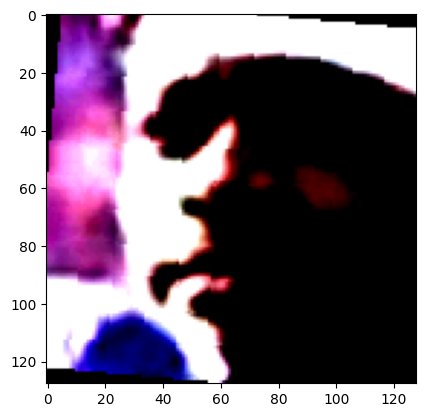

In [ ]:
plt.imshow(imgs[10].permute(1, 2, 0))

#Model

In [ ]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 1, bias=True)  #


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]


In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#output size of model

In [ ]:
model(imgs).shape

torch.Size([128, 1])

#Custom model

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

#creating object for Model (device. loss, otimizer, metric)

In [ ]:
model = AgeEstimationModel()
model(imgs).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 87.4MB/s]


torch.Size([128, 1])

#Config the model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
metric = tm.MeanAbsoluteError().to(device)
metric

MeanAbsoluteError()

#Utils

In [ ]:
# in baraye jam karadane tamame loss ha az tamame batch haa, loss_total ()
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:  #unit='batch' neshoon mide per sample to khoroji (x/sec)
    for inputs, targets in tepoch:
      #writing the epoch number in the progress bar.
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets) #loss for each batch
      loss.backward()  # here models needs space in RAM for gradients (coz it's in train mode)
      optimizer.step()
      optimizer.zero_grad()
      loss_train.update(loss.item(), n=len(targets)) #loss ro mide without tensor and in chizaa..., len(targets): size e akharin batch ro check kone ke kamtar nabashe
      metric.update(outputs, targets)                #vaghti update benevisim output ro print yaa return nemikone
      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item()) #etelaate loss ro ham behemoon mide j, progress bar baa dastoor set_postfix/

  return model, loss_train.avg, metric.compute().item()

#Evaluation

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter() #loss total
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))
      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

In [ ]:
evaluate(model, valid_loader, loss_fn, metric)

(32.2095941776852, 32.2095947265625)

In [ ]:
# torch.cuda.empty_cache()

# temp = torch.tensor(1, device=device)
# model = temp.clone()
# optimizer = temp.clone()
# inputs = temp.clone()
# targets = temp.clone()
# outputs = temp.clone()

#Main Loop (Main Train)

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.001
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
# 2) Building the saving path
import os
SAVE_DIR = '/content/drive/MyDrive/models'
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    # torch.save(model, f'model.pt')
    torch.save(model, os.path.join(SAVE_DIR, 'model.pt'))
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 127/127 [01:53<00:00,  1.12batch/s, loss=8.17, metric=8.17]


Model Saved!
Valid: Loss = 7.113, MAE = 7.113



Epoch 1: 100%|██████████| 127/127 [01:53<00:00,  1.12batch/s, loss=6.27, metric=6.27]


Model Saved!
Valid: Loss = 6.433, MAE = 6.433



Epoch 2: 100%|██████████| 127/127 [01:55<00:00,  1.10batch/s, loss=5.67, metric=5.67]


Model Saved!
Valid: Loss = 5.692, MAE = 5.692



Epoch 3: 100%|██████████| 127/127 [01:55<00:00,  1.10batch/s, loss=5.4, metric=5.4]


Valid: Loss = 6.098, MAE = 6.098



Epoch 4: 100%|██████████| 127/127 [01:54<00:00,  1.11batch/s, loss=5.15, metric=5.15]


Model Saved!
Valid: Loss = 5.394, MAE = 5.394



Epoch 5: 100%|██████████| 127/127 [01:55<00:00,  1.10batch/s, loss=4.96, metric=4.96]


Model Saved!
Valid: Loss = 5.287, MAE = 5.287



Epoch 6: 100%|██████████| 127/127 [01:55<00:00,  1.10batch/s, loss=4.72, metric=4.72]


Valid: Loss = 5.355, MAE = 5.355



Epoch 7: 100%|██████████| 127/127 [01:54<00:00,  1.11batch/s, loss=4.6, metric=4.6]


Model Saved!
Valid: Loss = 5.203, MAE = 5.203



Epoch 8: 100%|██████████| 127/127 [01:54<00:00,  1.11batch/s, loss=4.44, metric=4.44]


Model Saved!
Valid: Loss = 5.104, MAE = 5.104



Epoch 9: 100%|██████████| 127/127 [01:54<00:00,  1.11batch/s, loss=4.23, metric=4.23]


Model Saved!
Valid: Loss = 5.059, MAE = 5.059



#plot

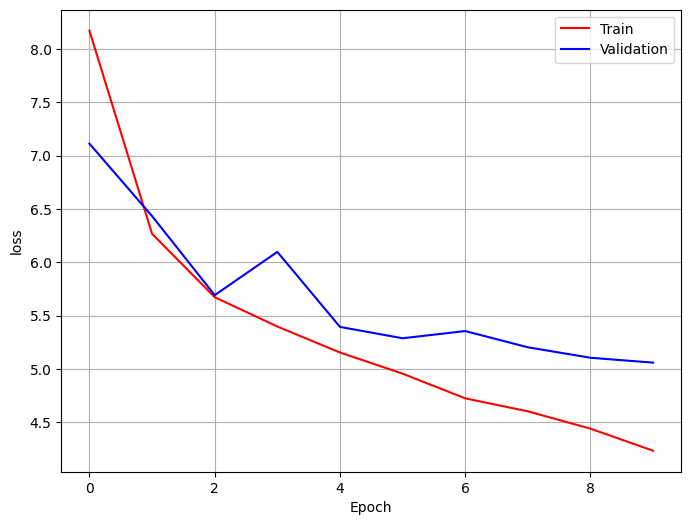

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#Test

In [ ]:
model = torch.load('/content/drive/MyDrive/models/model.pt', weights_only=False)
model.eval()

AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
_, metric_train = evaluate(model, train_loader, loss_fn, metric)
_, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
_, metric_test = evaluate(model, test_loader, loss_fn, metric)

metric_train, metric_valid, metric_test

(3.9509189128875732, 5.058638572692871, 4.9206862449646)

#Inference (Prediction)

In [ ]:
!pip install face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=a0de1d662e75620d1bfb00df15a74efe48a2026136925a9ffd868dab7830db2e
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models


In [ ]:
import face_recognition   #to extract the face

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving n24.jpg to n24.jpg


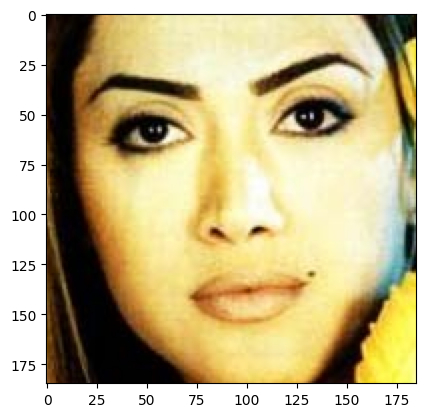

In [ ]:
img = face_recognition.load_image_file('/content/n24.jpg')  # array
top, right, bottom, left = face_recognition.face_locations(img)[0]  #face (tuple)
img_crop = img[top:bottom, left:right]  #crop and then getting size of the new image
plt.imshow(img_crop);

In [ ]:
img_crop = Image.fromarray(img_crop)  #converting from array to PIL
img_tensor = test_transform(img_crop).unsqueeze(0)  # add a dimension for converting to batch
img_tensor.shape  # it's tensor not batch , for batch we need 4 dimensions, it needs more dimension which refers to batch size, in index 0.

torch.Size([1, 3, 128, 128])

#giving test image to model

In [ ]:
with torch.inference_mode():
  preds = model(img_tensor.to(device)).item() #input and weights should be on the same device/ age just in number form
preds

22.001264572143555

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:  #if face_detection is active or true, do the below condes
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop)
  else:  #if face_detection is not true:
    img_crop = Image.open(image_path).convert('RGB')


  #az beyne 2 halate bala image is created, and then the rest of work.
  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds = model(img_tensor.to(device)).item()

  return preds, img_crop

22.00


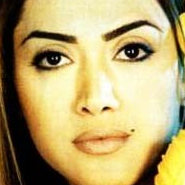

In [ ]:
preds, img = inference('/content/n24.jpg',
          test_transform, model, face_detection=True)

print(f'{preds:.2f}')  # two digits (do raghame a'ashaar)
img

#choosing randomly images and show them for prediction

Real: 93, Predicted: 67.83


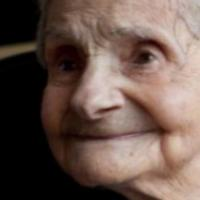

In [ ]:
folder_image_path = '/content/UTKFace/utkcropped/'
image_files = os.listdir(folder_image_path)

rand_idx = random.randint(0, len(image_files))
test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = image_files[rand_idx].split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

#choosing from csv file and show them for prediction

Real: 21, Predicted: 27.05


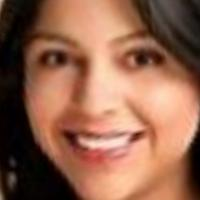

In [ ]:
# Load a random image from a casv file
#this code choose randomly a sample from csv file and then getting its name and making its address and give it to model and show the image and its predction.


csv_file_path = '/content/test_set.csv'
df = pd.read_csv(csv_file_path)

rand_idx = random.randint(0, df.shape[0])
test_image_name = df.iloc[rand_idx].image_name #reading sth frim csv file with iloc
test_image_path = os.path.join(folder_image_path, test_image_name)
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

#Experiment

In [ ]:
all_outputs, all_targets = [], []

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    outputs = model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

In [ ]:
all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()
all_outputs.shape, all_targets.shape

(torch.Size([3475]), torch.Size([3475]))

In [ ]:
#mae = F.l1_loss(all_outputs, all_targets) #MAE for all samples and gives just one value
mae = F.l1_loss(all_outputs, all_targets, reduction='none') # using reduction: MAE for each sample (every single of samples)
mae.shape #size of MAE vector

torch.Size([3475])

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')

df_test['preds'] = all_outputs.cpu()         #add one column to test.csv and transfer from gpu to cpu
df_test['maes'] = mae.cpu()                  #add one column to test.csv and transfer from gpu to cpu
df_test.to_csv('/content/test_outputs.csv')  #saving the new csv
df_test.head()

,image_name,age,ethnicity,gender,preds,maes
0,56_0_0_20170111202409002.jpg.chip.jpg,56,White,Male,47.801186,8.198814
1,48_0_3_20170119200357284.jpg.chip.jpg,48,Indian,Male,49.630722,1.630722
2,34_0_0_20170117141607879.jpg.chip.jpg,34,White,Male,35.233955,1.233955
3,46_0_1_20170111200735373.jpg.chip.jpg,46,Black,Male,50.477783,4.477783
4,4_1_0_20170104005345015.jpg.chip.jpg,4,White,Female,7.888597,3.888597


#age

In [ ]:
df_test.groupby('age')['maes'].describe() #gives information for each age class (statistical information for age)
                                          #number of samples for each age

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,168.0,1.318563,7.565518,0.002292,0.146446,0.293079,0.676820,80.807884
2,72.0,0.901519,0.875477,0.032152,0.304302,0.628871,1.132610,4.470342
3,43.0,1.488675,1.392709,0.111540,0.558717,1.017348,1.733119,5.612576
4,41.0,2.910390,3.940681,0.087761,0.625532,1.646010,3.199433,17.769905
5,29.0,4.452508,11.775430,0.030476,0.846677,2.137427,2.965683,64.809174
...,...,...,...,...,...,...,...,...
76,8.0,16.320621,9.691339,0.633499,13.046753,14.995514,21.287022,33.572422
77,4.0,3.044819,2.541901,0.617828,1.288223,2.625854,4.382450,6.309738
78,10.0,10.543367,6.408800,0.543289,7.616306,10.467804,14.413098,20.249451


<BarContainer object of 80 artists>

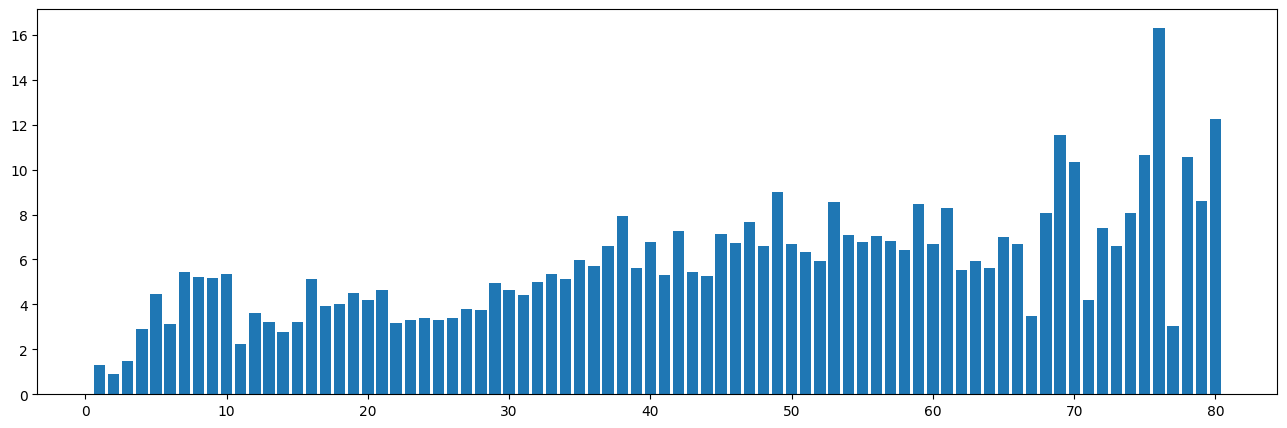

In [ ]:
#plt.bar(x,h) -->x: number of bars, h: height of bars

plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,     #.index -->gives column of age
        df_test.groupby('age')['maes'].describe()['mean'])   # mean -->gives information for mean column

#it shows the error for ages less than 40 is less but after that we dont have good accuracy
#it's because we dont that much samples for ages after 40. So we can add more samples from other datasets to compensate this problem.

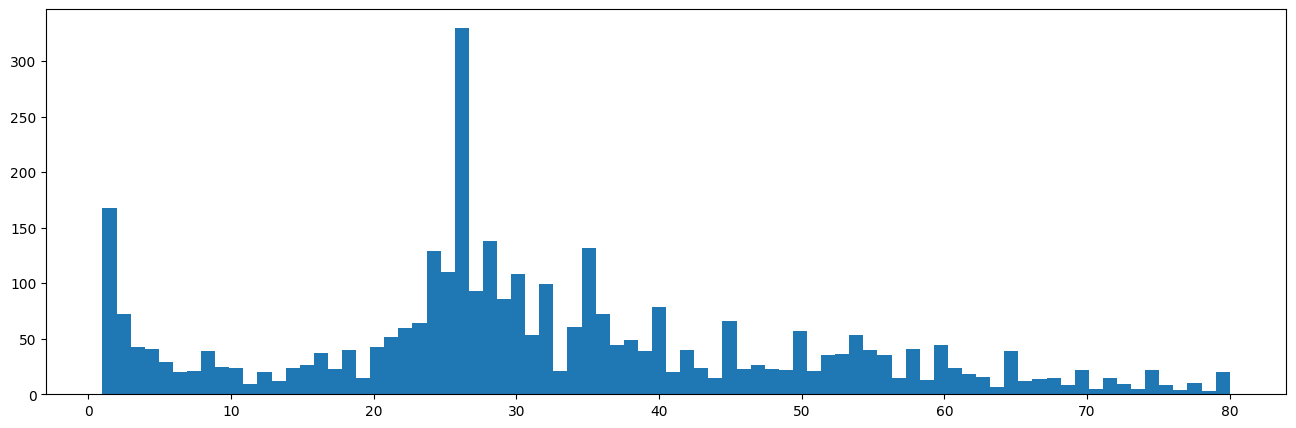

In [ ]:
plt.figure(figsize=(16, 5))
plt.hist(df_test.age, bins=len(df_test.age.unique()));

#compare this histogram with upper one, shows whereever we have less number of samples, we will have more errors.

#if we add more samples in ages that we dont have that much information, we can have a uniform histogram.

#gender

In [ ]:
df_test.groupby('gender')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1641.0,4.637274,4.648045,0.006319,1.348911,3.177830,6.340689,35.048889
Male,1834.0,5.174274,5.609380,0.002292,1.423938,3.581376,7.362890,80.807884


#ethnicity

In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,512.0,3.839427,5.449562,0.002292,0.674434,2.206663,5.312141,80.807884
Black,664.0,5.503973,5.491501,0.016293,1.915280,3.892476,7.347706,64.809174
Indian,591.0,4.723560,4.318696,0.015495,1.332049,3.470798,6.935598,22.987823
Others,245.0,4.272678,5.253901,0.014301,1.039524,2.665514,5.920742,56.680531
White,1463.0,5.222507,5.188910,0.006317,1.566586,3.657684,7.286773,54.788033


In [ ]:
ranges = np.arange(df.age.min()-1, df.age.max()+1, 5)
df_test['age_period'] = pd.cut(df.age, bins=ranges)    #it makes ranges..it shows every sample in its corresponding range.
df_test.head()

,image_name,age,ethnicity,gender,preds,maes,age_period
0,56_0_0_20170111202409002.jpg.chip.jpg,56,White,Male,47.801186,8.198814,"(55, 60]"
1,48_0_3_20170119200357284.jpg.chip.jpg,48,Indian,Male,49.630722,1.630722,"(45, 50]"
2,34_0_0_20170117141607879.jpg.chip.jpg,34,White,Male,35.233955,1.233955,"(30, 35]"
3,46_0_1_20170111200735373.jpg.chip.jpg,46,Black,Male,50.477783,4.477783,"(45, 50]"
4,4_1_0_20170104005345015.jpg.chip.jpg,4,White,Female,7.888597,3.888597,"(0, 5]"


#showing error in each range

/tmp/ipython-input-423940393.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby('age_period')['maes'].describe()['mean']);


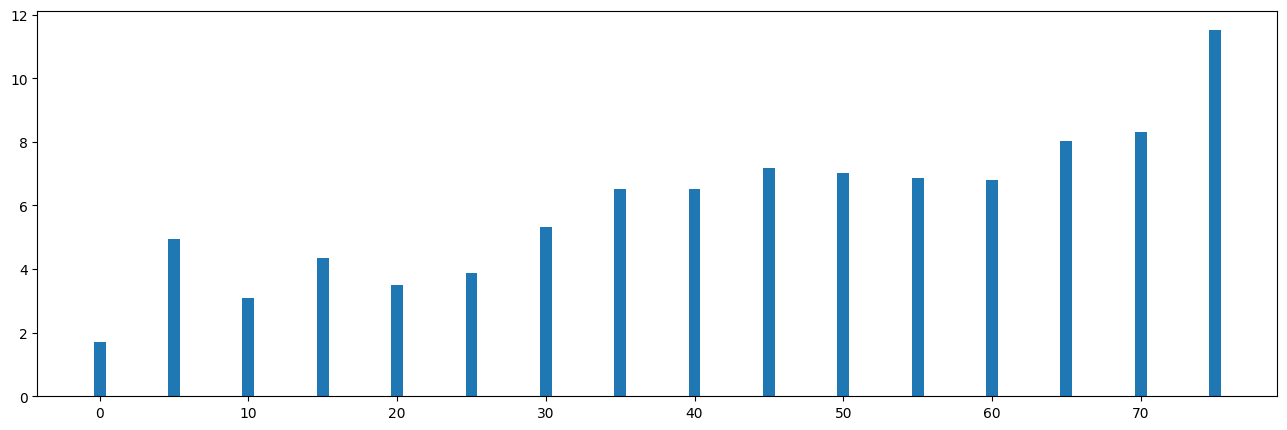

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(ranges[:-1],
        df_test.groupby('age_period')['maes'].describe()['mean']);

In [ ]:
df_test.groupby('age_period')['maes'].describe().index

/tmp/ipython-input-3698497964.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby('age_period')['maes'].describe().index


CategoricalIndex([  (0, 5],  (5, 10], (10, 15], (15, 20], (20, 25], (25, 30],
                  (30, 35], (35, 40], (40, 45], (45, 50], (50, 55], (55, 60],
                  (60, 65], (65, 70], (70, 75], (75, 80]],
                 categories=[(0, 5], (5, 10], (10, 15], (15, 20], ..., (60, 65], (65, 70], (70, 75], (75, 80]], ordered=True, dtype='category', name='age_period')

In [ ]:
df_test.groupby('age_period')['maes'].describe()  #seeing errors in each age range

/tmp/ipython-input-71-4209873241.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby('age_period')['maes'].describe()  #seeing errors in each age range


,count,mean,std,min,25%,50%,75%,max
age_period,,,,,,,,
"(0, 5]",353.0,1.363155,5.051301,0.007492,0.177002,0.481132,1.198217,82.915062
"(5, 10]",129.0,2.971692,3.371374,0.004175,0.986310,1.877076,3.838320,22.632282
"(10, 15]",91.0,4.744778,5.575984,0.323694,1.786800,3.303731,6.241120,42.367695
"(15, 20]",158.0,4.968265,3.218647,0.060099,2.642425,4.835247,6.609323,22.596886
"(20, 25]",415.0,2.625905,2.573332,0.000036,0.903766,1.997263,3.437558,19.183041
"(25, 30]",755.0,3.026265,3.086604,0.000675,1.030441,2.316629,3.985571,34.318058
"(30, 35]",366.0,5.625201,3.864341,0.015928,2.667166,5.087312,7.648084,23.288830
"(35, 40]",283.0,7.314577,4.432040,0.070972,3.521452,7.271820,10.591743,19.283615
"(40, 45]",165.0,8.272300,5.488943,0.018661,3.655727,7.561821,12.636116,22.528389


#Analysis the model's sensitivity

22.34


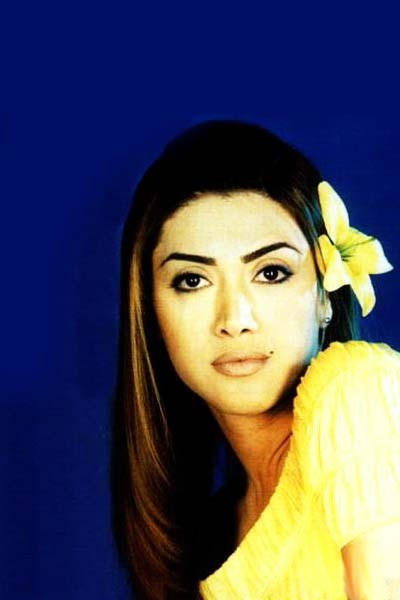

In [ ]:
test_image_path = '/content/n24.jpg'
img = Image.open(test_image_path).convert('RGB')

img_tensor = test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age = model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

In [ ]:
import torch, numpy as np

model.eval()
y_true_list, y_pred_list = [], []

with torch.inference_mode():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().view(-1)      # [N]
        pb = model(xb).view(-1)                  # [N]
        y_true_list.append(yb.cpu())
        y_pred_list.append(pb.cpu())

y_true = torch.cat(y_true_list).numpy()
y_pred = torch.cat(y_pred_list).numpy()

abs_err = np.abs(y_pred - y_true)
mae   = abs_err.mean()
rmse  = np.sqrt(((y_pred - y_true)**2).mean())
medae = np.median(abs_err)
r2    = 1 - ((y_pred - y_true)**2).sum() / ((y_true - y_true.mean())**2).sum()

acc_within5 = (abs_err <= 5).mean() * 100  # درصد داخل ±5 سال
acc_within3 = (abs_err <= 3).mean() * 100  # درصد داخل ±3 سال

# Relative error percentage
mape = (abs_err / np.clip(np.abs(y_true), 1e-6, None)).mean() * 100

print(f"MAE: {mae:.2f} yrs | MedianAE: {medae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f}")
print(f"Within ±5 yrs: {acc_within5:.1f}% | Within ±3 yrs: {acc_within3:.1f}%")
print(f"MAPE: {mape:.1f}% (use with care)")


MAE: 4.92 yrs | MedianAE: 3.38 | RMSE: 7.15 | R^2: 0.846
Within ±5 yrs: 63.9% | Within ±3 yrs: 45.6%
MAPE: 24.9% (use with care)


In [ ]:
import numpy as np
Ks = np.arange(0, 11)  # year: 0..10
cov = [(np.abs(y_pred - y_true) <= k).mean()*100 for k in Ks]
for k, c in zip(Ks, cov):
    print(f"±{k}y: {c:.1f}%")


±0y: 0.0%
±1y: 19.2%
±2y: 32.7%
±3y: 45.6%
±4y: 55.9%
±5y: 63.9%
±6y: 70.0%
±7y: 75.5%
±8y: 80.3%
±9y: 83.7%
±10y: 87.3%


In [ ]:
bins = np.arange(0, 81, 10)  #  10 year periods
idx = np.digitize(y_true, bins)-1
for b in range(len(bins)-1):
    m = idx==b
    if m.any():
        mae = np.abs(y_pred[m]-y_true[m]).mean()
        me  = (y_pred[m]-y_true[m]).mean()    # بایاس؛ ideally ~0
        print(f"{bins[b]:02d}-{bins[b+1]-1:02d}: MAE={mae:.2f}, Bias={me:+.2f}")


00-09: MAE=2.42, Bias=+1.87
10-19: MAE=3.99, Bias=+2.63
20-29: MAE=3.66, Bias=+1.50
30-39: MAE=5.54, Bias=-1.36
40-49: MAE=6.86, Bias=-1.59
50-59: MAE=6.93, Bias=-2.74
60-69: MAE=6.81, Bias=-3.57
70-79: MAE=9.39, Bias=-8.36


In [ ]:
#The worst cases

In [ ]:
err = np.abs(y_pred - y_true)
worst_idx = err.argsort()[-10:][::-1]  # 10 samples with the worst error
print(list(zip(worst_idx, err[worst_idx], y_true[worst_idx], y_pred[worst_idx])))


[(np.int64(612), np.float32(80.807884), np.float32(1.0), np.float32(81.807884)), (np.int64(1299), np.float32(64.80917), np.float32(5.0), np.float32(69.80917)), (np.int64(3374), np.float32(56.68053), np.float32(1.0), np.float32(57.68053)), (np.int64(918), np.float32(54.788033), np.float32(8.0), np.float32(62.788033)), (np.int64(2455), np.float32(41.353737), np.float32(9.0), np.float32(50.353737)), (np.int64(1280), np.float32(35.04889), np.float32(69.0), np.float32(33.95111)), (np.int64(2919), np.float32(33.572422), np.float32(76.0), np.float32(42.427578)), (np.int64(964), np.float32(32.666374), np.float32(7.0), np.float32(39.666374)), (np.int64(2093), np.float32(30.504524), np.float32(31.0), np.float32(61.504524)), (np.int64(1538), np.float32(30.071178), np.float32(60.0), np.float32(29.928822))]
